In [4]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_log_error,r2_score

In [5]:
# Cargar los archivos en DataFrames
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_oil = pd.read_csv("oil.csv")
df_stores = pd.read_csv("stores.csv")
df_holidays = pd.read_csv("holidays_events.csv")
df_transactions = pd.read_csv("transactions.csv")

# Ver las primeras filas de cada dataset
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# ANÁLISIS EXPLORATORIO

In [6]:
#Dimensiones del dataset train
df_train.shape

(3000888, 6)

In [7]:
#Tipo de variable del dataset
df_train.dtypes

,0
id,int64
date,object
store_nbr,int64
family,object
sales,float64
onpromotion,int64


In [8]:
#Convertir variable date a datetime
df_train["date"] = pd.to_datetime(df_train['date'])

In [9]:
# Visualizar la evolución de las ventas a lo largo del tiempo en train.csv
sales_by_date = df_train.groupby("date")["sales"].sum()

# Graficar ventas totales por día
fig = px.line(sales_by_date, labels={'index': 'Fecha', 'value': 'Ventas totales'}, title='Evolución de las ventas a lo largo del tiempo')
fig.update_traces(name='Ventas diarias', line=dict(color='blue'))
fig.show()

ESTUDIO ESTACIONALIDAD

In [10]:
# Extraer día de la semana y mes para analizar patrones estacionales
df_train["day_of_week"] = df_train["date"].dt.dayofweek
df_train["month"] = df_train["date"].dt.month
df_train["year"] = df_train["date"].dt.year

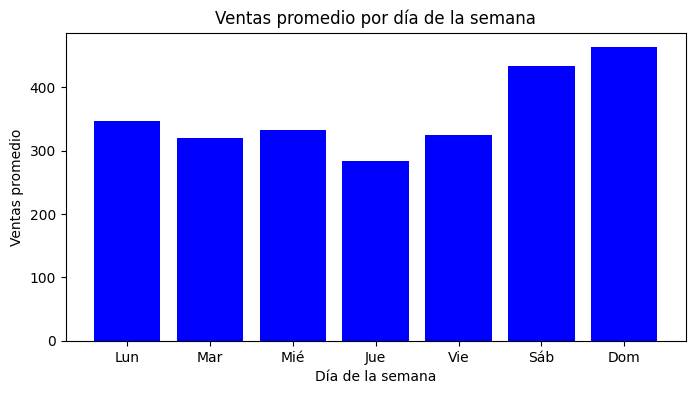

In [11]:
# Agrupar ventas por día de la semana
sales_by_day = df_train.groupby("day_of_week")["sales"].mean()

# Graficar ventas promedio por día de la semana
plt.figure(figsize=(8, 4))
plt.bar(sales_by_day.index, sales_by_day.values, color="blue")
plt.xticks(ticks=range(7), labels=["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"])
plt.xlabel("Día de la semana")
plt.ylabel("Ventas promedio")
plt.title("Ventas promedio por día de la semana")
plt.show()

Como podemos observar, en sábado y domingo se incrementan las ventas, por lo que sería recomendable crear un campo de tipo binario para hacer hincapié en esta diferencia.

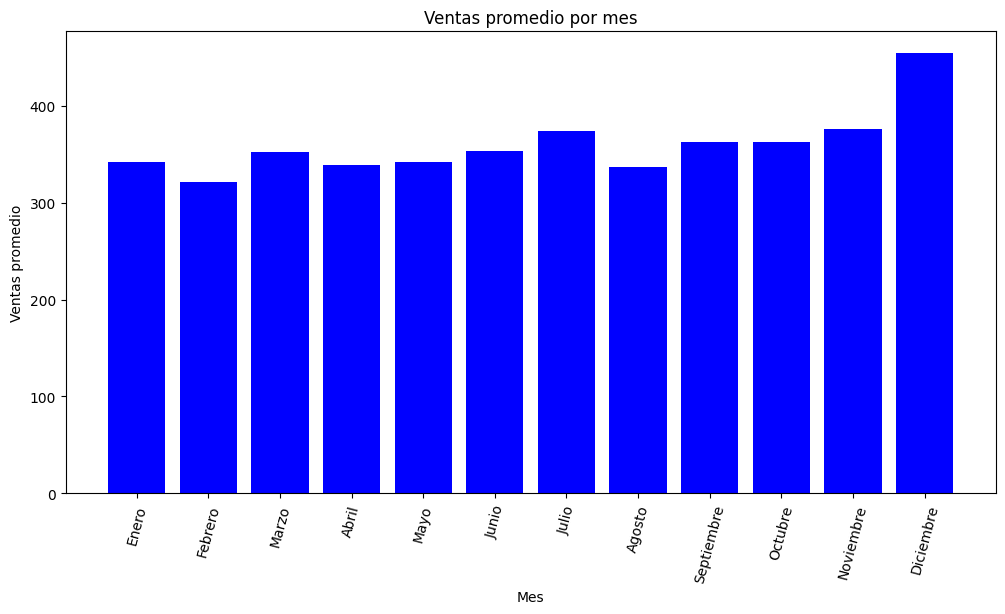

In [12]:
# Agrupar ventas por mes
sales_by_month = df_train.groupby("month")["sales"].mean()

# Graficar ventas promedio por mes
plt.figure(figsize=(12, 6))
plt.bar(sales_by_month.index, sales_by_month.values, color="blue")
plt.xlabel("Mes")
plt.ylabel("Ventas promedio")
plt.xticks(sales_by_month.index, ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'], rotation = 75)
plt.title("Ventas promedio por mes")
plt.show()

En cuanto a los meses, sobresale el mes de diciembre, mes señalado en el calendario por ser época navideña.

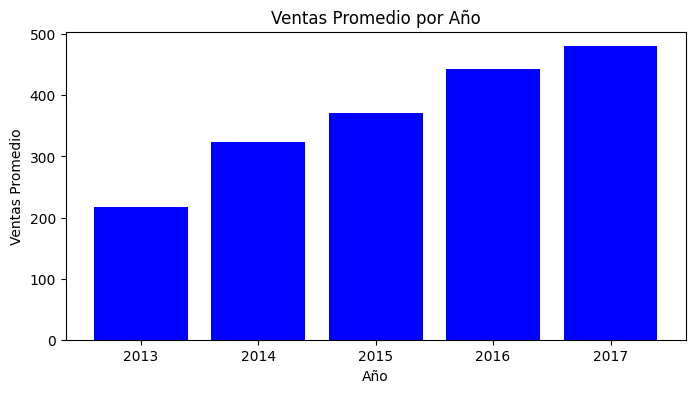

In [13]:
# #Agrupar ventas por año
sales_by_year = df_train.groupby("year")["sales"].mean()

#Garficar ventas promedio por año
plt.figure(figsize=(8,4))
plt.bar(sales_by_year.index, sales_by_year.values, color = "blue")
plt.title('Ventas Promedio por Año')
plt.xlabel('Año')
plt.ylabel('Ventas Promedio')
plt.xticks(sales_by_year.index, ['2013', '2014', '2015', '2016', '2017'])
plt.show()

En términos anuales podemos apreciar una tendencia alcista de las ventas.

**On Promotion**

El impacto de promociones (onpromotion) en las ventas.

<ipython-input-14-851eed1794fe>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Correlación entre ventas y promociones: 0.43


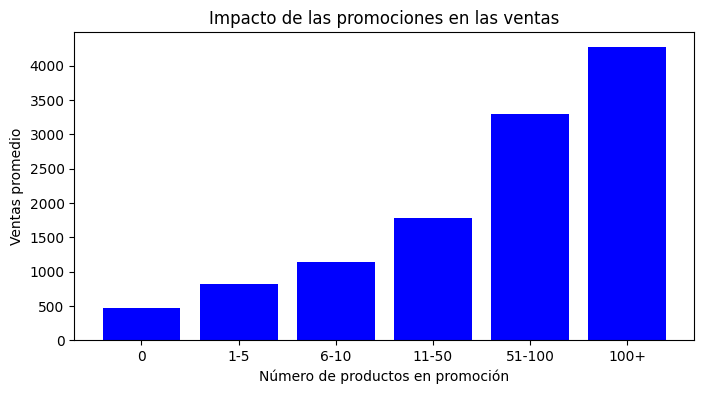

In [14]:
# Crear bins para agrupar los productos en promoción en rangos
df_train["onpromotion_bins"] = pd.cut(df_train["onpromotion"], bins=[0, 1, 5, 10, 50, 100, np.inf], labels=["0", "1-5", "6-10", "11-50", "51-100", "100+"])

# Calcular las ventas promedio por cada grupo de promociones
sales_by_promotion = df_train.groupby("onpromotion_bins")["sales"].mean()

#Correlación entre promciones y ventas
correlation = df_train["sales"].corr(df_train["onpromotion"])
print(f"Correlación entre ventas y promociones: {correlation:.2f}")

# Graficar el impacto de las promociones en las ventas
plt.figure(figsize=(8, 4))
plt.bar(sales_by_promotion.index.astype(str), sales_by_promotion.values, color="blue")
plt.xlabel("Número de productos en promoción")
plt.ylabel("Ventas promedio")
plt.title("Impacto de las promociones en las ventas")
plt.show()

df_train.drop("onpromotion_bins",axis=1, inplace = True)


Podemos observar una relación positiva entre las promociones y las ventas:

A medida que aumenta el número de productos en promoción, las ventas promedio también tienden a subir.
Esto sugiere que los descuentos y ofertas pueden ser un factor clave en la demanda de productos.
No obstante, siguen un patrón no lineal, ya que los efectos de las promociones no son estrictamente proporcionales; hay umbrales donde el impacto es más notorio.
Puediendo haber un punto en el que a más promociones no se genere un aumento significativo en las ventas.

**Variables categóricas**

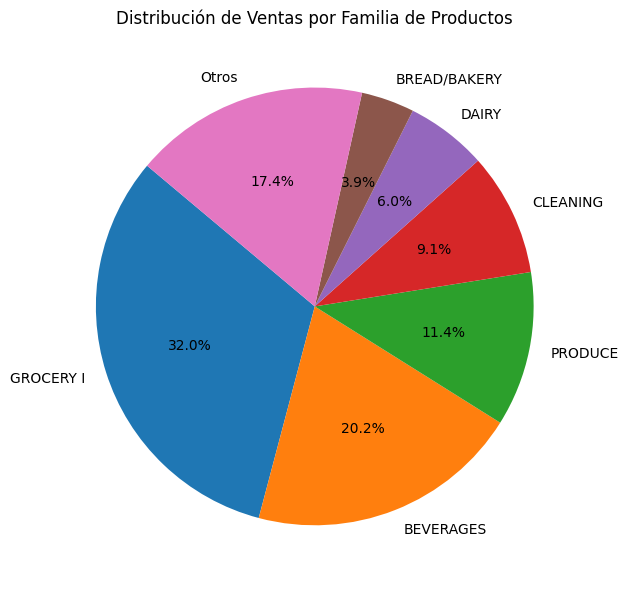

In [15]:
# Agrupar por familia y calcular la media de ventas
fam_productos = df_train.groupby('family')['sales'].mean().sort_values(ascending=False)

# Definir umbral de ventas mínimas para mostrar
umbral = 0.03 * fam_productos.sum()

# Filtrar familias con ventas significativas y agrupar las pequeñas en "Otros"
familias_filtradas = fam_productos[fam_productos >= umbral]
otros = fam_productos[fam_productos < umbral].sum()
familias_filtradas["Otros"] = otros

# Graficar
plt.figure(figsize=(12, 6))
plt.pie(familias_filtradas.values.tolist(), labels =familias_filtradas.index.tolist(), autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Ventas por Familia de Productos')
plt.tight_layout()
plt.show()


Las familias de productos con mayores ventas son Grocery I, Beverages, Produce, Cleaning y Dairy, las cuales copan cerca del 80 % de las ventas

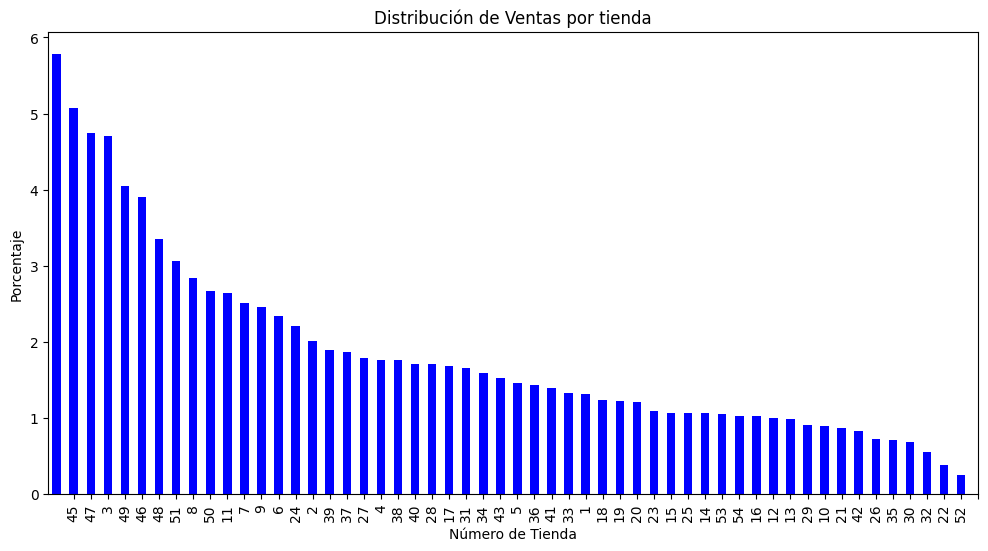

In [16]:
#Observar aquellas tiendas con mayores ventas
tienda = df_train.groupby('store_nbr')['sales'].mean().sort_values(ascending=False)
prueba = ((tienda/ tienda.sum()) * 100).sort_values(ascending=False)

#Generar gráfico
plt.figure(figsize=(12,6))
prueba.plot(kind='bar', color = 'blue')
plt.xlabel('Número de Tienda')
plt.ylabel('Porcentaje')
plt.xticks(prueba.index)
plt.title('Distribución de Ventas por tienda')
plt.show()

El impacto de días festivos (df_holidays) en las ventas.

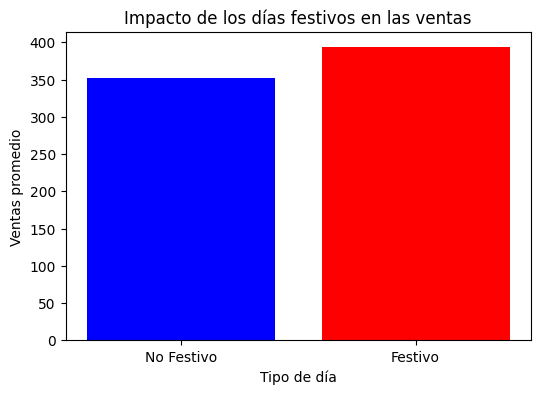

In [17]:
# Convertir las fechas de df_holidays a datetime
df_holidays["date"] = pd.to_datetime(df_holidays["date"])

# Unir los datos de ventas con los festivos
df_train_holidays = df_train.merge(df_holidays, on="date", how="left")

# Crear una columna binaria para indicar si el día es festivo o no
df_train_holidays["is_holiday"] = df_train_holidays["type"].notna().astype(int)

# Calcular las ventas promedio en días festivos y no festivos
sales_by_holiday = df_train_holidays.groupby("is_holiday")["sales"].mean()

# Graficar el impacto de los festivos en las ventas
plt.figure(figsize=(6, 4))
plt.bar(["No Festivo", "Festivo"], sales_by_holiday.values, color=["blue", "red"])
plt.xlabel("Tipo de día")
plt.ylabel("Ventas promedio")
plt.title("Impacto de los días festivos en las ventas")
plt.show()

**Relación entre ventas y transacciones completas**

Correlación entre ventas y transacciones: 0.84


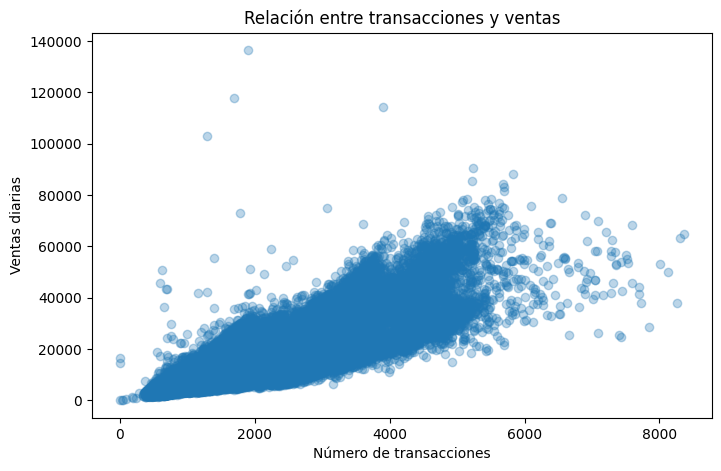

In [18]:
# Convertir fechas a formato datetime
df_transactions["date"] = pd.to_datetime(df_transactions["date"])

# Agregar las ventas diarias por tienda
df_sales_by_store = df_train.groupby(["date", "store_nbr"])["sales"].sum().reset_index()

# Unir las ventas con el número de transacciones
df_merged = df_sales_by_store.merge(df_transactions, on=["date", "store_nbr"], how="left")

# Calcular la correlación entre ventas y transacciones
correlation = df_merged["sales"].corr(df_merged["transactions"])
print(f"Correlación entre ventas y transacciones: {correlation:.2f}")

# Graficar la relación entre transacciones y ventas
plt.figure(figsize=(8, 5))
plt.scatter(df_merged["transactions"], df_merged["sales"], alpha=0.3)
plt.xlabel("Número de transacciones")
plt.ylabel("Ventas diarias")
plt.title("Relación entre transacciones y ventas")
plt.show()

**Relación entre petróleo y ventas**

Correlación entre ventas y precio del petróleo: -0.07


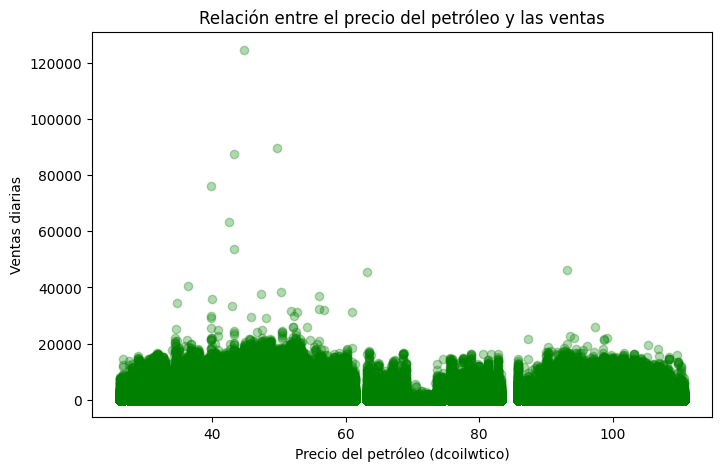

In [19]:
# Convertir fechas a formato datetime
df_oil["date"] = pd.to_datetime(df_oil["date"])

# Unir los datos de ventas con los precios del petróleo
df_train_oil = df_train.merge(df_oil, on="date", how="left")

# Manejar valores nulos en el precio del petróleo con interpolación
df_train_oil["dcoilwtico"] = df_train_oil["dcoilwtico"].interpolate()

# Calcular la correlación entre el precio del petróleo y las ventas
correlation_oil = df_train_oil["sales"].corr(df_train_oil["dcoilwtico"])
print(f"Correlación entre ventas y precio del petróleo: {correlation_oil:.2f}")

# Graficar la relación entre el precio del petróleo y las ventas
plt.figure(figsize=(8, 5))
plt.scatter(df_train_oil["dcoilwtico"], df_train_oil["sales"], alpha=0.3, color="green")
plt.xlabel("Precio del petróleo (dcoilwtico)")
plt.ylabel("Ventas diarias")
plt.title("Relación entre el precio del petróleo y las ventas")
plt.show()

# INGENERÍA DE VARIABLES

In [20]:
# Cargar los datos

df_train = pd.read_csv("train.csv")
df_transactions = pd.read_csv("transactions.csv")
df_oil = pd.read_csv("oil.csv")

# Convertir fechas a datetime
df_train["date"] = pd.to_datetime(df_train["date"])
df_transactions["date"] = pd.to_datetime(df_transactions["date"])
df_oil["date"] = pd.to_datetime(df_oil["date"])

# Unir transacciones con los datos de ventas
df_train = df_train.merge(df_transactions, on=["date", "store_nbr"], how="left")

# Manejar valores nulos en transacciones (puede haber tiendas sin datos de transacciones)
df_train["transactions"].fillna(0, inplace=True)

# Unir los datos de ventas con los precios del petróleo
df_train = df_train.merge(df_oil, on="date", how="left")

# Manejar valores nulos en el precio del petróleo con interpolación
df_train["dcoilwtico"] = df_train["dcoilwtico"].interpolate()

# Extraer características temporales para tendencias y estacionalidad
df_train["year"] = df_train["date"].dt.year
df_train["month"] = df_train["date"].dt.month
df_train["day"] = df_train["date"].dt.day
df_train["day_of_week"] = df_train["date"].dt.dayofweek  # Lunes = 0, Domingo = 6
df_train["week_of_year"] = df_train["date"].dt.isocalendar().week
df_train["is_weekend"] = (df_train["day_of_week"] >= 5).astype(int)  # 1 si es sábado o domingo

<ipython-input-20-ed053043a85d>:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [21]:
# Mostrar dataset con las nuevas características
df_train.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,dcoilwtico,year,month,day,day_of_week,week_of_year,is_weekend
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,NaN,2013,1,1,1,1,0
1,1,2013-01-01,1,BABY CARE,0.0,0,0.0,NaN,2013,1,1,1,1,0
2,2,2013-01-01,1,BEAUTY,0.0,0,0.0,NaN,2013,1,1,1,1,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,0.0,NaN,2013,1,1,1,1,0
4,4,2013-01-01,1,BOOKS,0.0,0,0.0,NaN,2013,1,1,1,1,0


# MODELADO Y VALIDACIÓN

XGBOOST

In [35]:
# Preparar los datos

# Definir una función para entrenar modelo por tienda y familia
def XGBOOST_model(data, tienda, familia):
    # Filtrar datos para la tienda y familia específica
    store_family_data = data[
        (data['store_nbr'] == tienda) &
        (data['family'] == familia)
    ].copy()

    if len(store_family_data) == 0:
        return None

    # Preparar división dataset
    X = store_family_data[['onpromotion',
       'transactions', 'dcoilwtico', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'is_weekend']]
    y = store_family_data['sales']

    # Dividir por fecha en lugar de aleatoriamente
    split_date = '2016-01-31'

    X_train = X[store_family_data['date'] <= split_date]
    X_val = X[store_family_data['date'] > split_date]
    y_train = y[store_family_data['date'] <= split_date]
    y_val = y[store_family_data['date'] > split_date]

    # Instanciar y entrenar el modelo
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    return model, X_val, y_val

# Obtener tiendas y familias únicas
stores = df_train['store_nbr'].unique()
families = df_train['family'].unique()

# Diccionario para almacenar modelos
models = {}
results = []

# Entrenar modelo para cada combinación de tienda y familia
for tienda in stores:
    for familia in families:
        #print(f"Entrenando modelo para tienda {tienda} y familia {familia}")

        model_result = XGBOOST_model(df_train, tienda, familia)

        if model_result is not None:
            model, X_val, y_val = model_result

            # Hacer predicciones
            y_pred = model.predict(X_val)

            # Calcular RMSE
            rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(y_pred, 0)))

            # Guardar resultados
            results.append({
                'store_nbr': tienda,
                'family': familia,
                'rmsle': rmsle
            })

            # Guardar modelo
            models[(tienda, familia)] = model

# Convertir resultados a DataFrame y mostrar resumen
results_df = pd.DataFrame(results)
print("\nResumen de RMSLE por tienda y familia:")
print(results_df.describe())


Resumen de RMSLE por tienda y familia:
         store_nbr        rmsle
count  1782.000000  1782.000000
mean     27.500000     0.660007
std      15.590159     0.452819
min       1.000000     0.000000
25%      14.000000     0.344078
50%      27.500000     0.568123
75%      41.000000     0.848348
max      54.000000     3.995122


RANDOM FORREST

In [36]:
df_train_RF = df_train.copy()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error,r2_score
import numpy as np

def randomforrest_model(dataset,tienda_RF,familia_RF):
    #Filtrar datos por tienda y producto específico
    dataset_RF = dataset[(dataset['store_nbr']== tienda_RF) & (dataset['family']== familia_RF)].copy()

    #Dividir el dataset
    X = dataset_RF[['onpromotion',
       'transactions', 'dcoilwtico', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'is_weekend']]
    y = dataset_RF['sales']

    # Dividir por fecha en lugar de aleatoriamente
    split_date = '2016-01-31'

    X_train = X[dataset_RF['date'] <= split_date]
    X_val = X[dataset_RF['date'] > split_date]
    y_train = y[dataset_RF['date'] <= split_date]
    y_val = y[dataset_RF['date'] > split_date]

#Instanciar modelo Random Forrest
    model_RF = RandomForestRegressor(random_state=42,
                                 n_estimators=200,
                                 max_depth=20,
                                 criterion="squared_error",
                                 max_features=None,
                                 bootstrap=True,
                                 oob_score=True,
                                 max_samples=0.6)
#Entrenar modelo
    model_RF.fit(X_train,y_train)

    return model_RF, X_val, y_val

# Obtener tiendas y familias únicas
stores = df_train_RF['store_nbr'].unique()
families = df_train_RF['family'].unique()

# Diccionario para almacenar modelos
models = {}
results = []

# Entrenar modelo para cada combinación de tienda y familia
for tienda_RF in stores:
    for familia_RF in families:
        #print(f"Entrenando modelo para tienda {tienda} y familia {familia}")

        model_result = randomforrest_model(df_train, tienda_RF, familia_RF)

        if model_result is not None:
            model_RF, X_val, y_val = model_result

            # Hacer predicciones
            y_pred = model_RF.predict(X_val)

            # Calcular RMSE
            rmsle = np.sqrt(mean_squared_log_error(y_val, np.maximum(y_pred, 0)))

            # Guardar resultados
            results.append({
                'store_nbr': tienda_RF,
                'family': familia_RF,
                'rmsle': rmsle
            })

            # Guardar modelo
            models[(tienda_RF, familia_RF)] = model_RF

# Convertir resultados a DataFrame y mostrar resumen
results_df = pd.DataFrame(results)
print("\nResumen de RMSLE por tienda y familia:")
print(results_df.describe())

XGBOOST GRADIENT(Mario)

ARIMA

In [ ]:
# Cargar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_log_error, r2_score, mean_absolute_error

df_train_series = df_train.copy()
# Agrupar ventas por fecha y asegurarnos de que la serie tiene un índice de fecha correcto
df_train_series = df_train_series.groupby("date")["sales"].sum()
df_train_series = df_train_series.asfreq("D")  # Asegurar frecuencia diaria

def ARIMA_model(data, store_arima, familia_arima):
    dataset_ARIMA = data[(data['store_nbr'] == store_arima) & (data['family'] == familia_arima)]

    # Aquí se define X pero no se utiliza, lo cual es un error
    X = dataset_ARIMA[['onpromotion',
       'transactions', 'dcoilwtico', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'is_weekend']]
    y = dataset_ARIMA['sales']

    # Dividir en entrenamiento y validación (últimos 30 días)
    split_date = df_train_series.index[-30]  # Últimos 30 días para validación
    df_train_series_train = df_train_series.loc[:split_date]
    df_train_series_test = df_train_series.loc[split_date:]

    # Instanciar el modelo ARIMA
    arima_model = ARIMA(df_train_series_train, order=(5, 1, 5))
    arima_result = arima_model.fit()

    return arima_result, df_train_series_test

store = df_train['store_nbr'].unique()
familia = df_train['family'].unique()

# Diccionario para almacenar modelos
models = {}
results = []

# Entrenar modelo para cada combinación de tienda y familia
for tienda_ARIMA in store:
    for familia_ARIMA in familia:

        #print(f"Entrenando modelo para tienda {tienda} y familia {familia}")
        model_result = ARIMA_model(df_train, tienda_ARIMA, familia_ARIMA)

        arima_result, df_train_series_test = model_result

        # Hacer predicciones
        y_pred = arima_result.predict(start=df_train_series_test.index[0], end=df_train_series_test.index[-1])

        # Calcular RMSE
        rmsle = np.sqrt(mean_squared_log_error(df_train_series_test, np.maximum(y_pred, 0)))

        # Guardar resultados
        results.append({
            'store_nbr': tienda_ARIMA,
            'family': familia_ARIMA,
            'rmsle': rmsle
        })

        # Guardar modelos
        models[(tienda_ARIMA, familia_ARIMA)] = arima_result

# Convertir resultados a DataFrame y mostrar resumen
results_df = pd.DataFrame(results)
print("\nResumen de RMSLE por tienda y familia:")
print(results_df.describe())

¿POR QUÉ PROPHET?

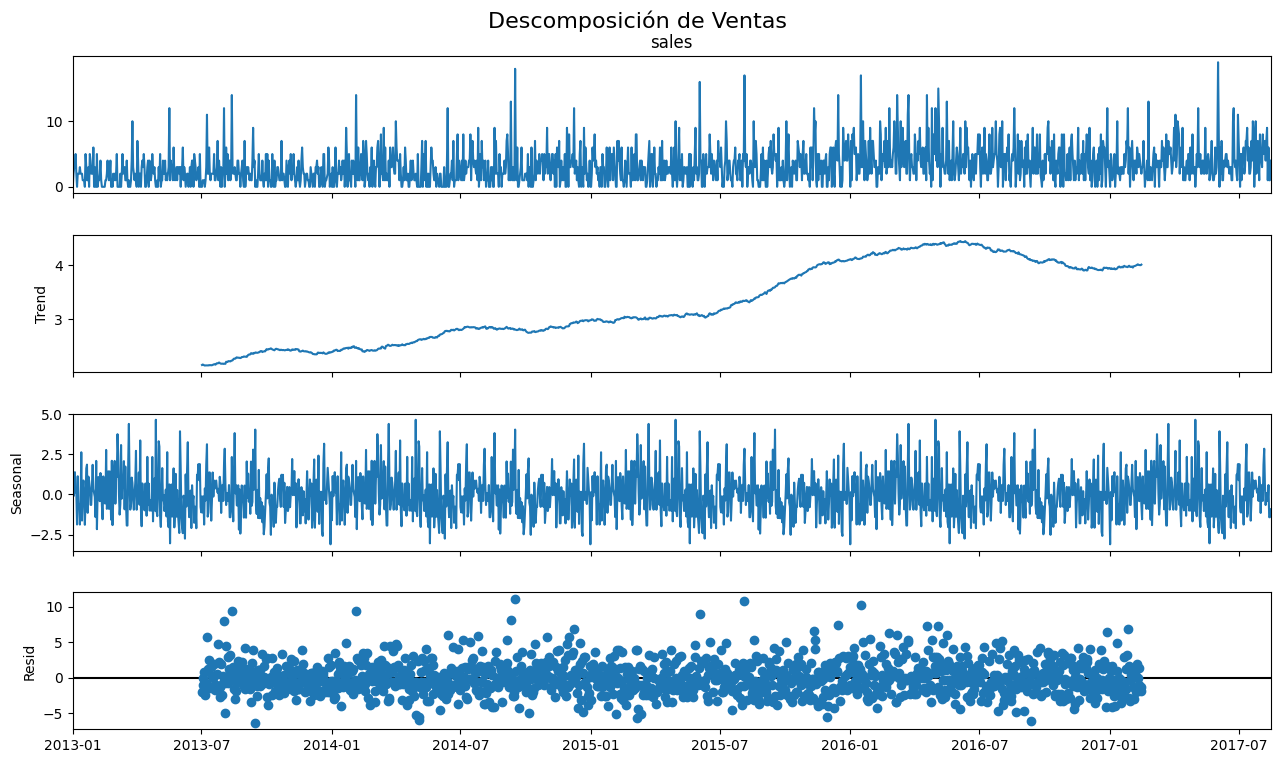

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df['sales'], model='additive', period=365)
fig = decomp.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Descomposición de Ventas', fontsize=16)
plt.show()

Como puede verse en el análisis gráfico anterior, Prophet se ajusta perfectamente a nuestro caso de uso, al tratarse de una predicción univariada, con tendencia y estacionalidad, el cual es el escenario perfecto para este modelo.

PROPHET BÁSICO SOBRE AGREGADO POR store_nbr y family

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm

# Cargar datos
df_train = pd.read_csv("train.csv")
df_train["date"] = pd.to_datetime(df_train["date"])

# Parámetros
validation_days = 30

# Crear dataframe vacío para almacenar resultados
rmsle_results = []

# Iterar sobre cada combinación de tienda y familia
for (store, family) in tqdm(df_train.groupby(["store_nbr", "family"]).size().index, desc="Validando Prophet"):

    # Filtrar por tienda y familia
    df_filtered = df_train[(df_train["store_nbr"] == store) & (df_train["family"] == family)]

    # Agregar ventas diarias
    df_series = df_filtered.groupby("date")["sales"].sum().reset_index()
    df_series.columns = ["ds", "y"]

    # Comprobar si hay suficientes datos
    if len(df_series) <= validation_days + 10:
        continue

    # Dividir en entrenamiento y validación (últimos 30 días)
    df_train_cv = df_series[:-validation_days]
    df_valid_cv = df_series[-validation_days:]

    # Entrenar modelo Prophet
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(df_train_cv)

    # Hacer predicciones
    forecast = model.predict(df_valid_cv[["ds"]])

    # Asegurar predicciones no negativas
    y_pred = np.maximum(forecast["yhat"].values, 0)
    y_true = df_valid_cv["y"].values

    # Calcular RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))

    # Almacenar resultado
    rmsle_results.append({
        "store_nbr": store,
        "family": family,
        "rmsle": rmsle
    })

# Resultados finales en DataFrame
results_df = pd.DataFrame(rmsle_results)

# Calcular RMSLE promedio global
mean_rmsle = results_df["rmsle"].mean()
print(f"RMSLE promedio global: {mean_rmsle:.4f}")

Validando Prophet:   0%|          | 0/1782 [00:00<?, ?it/s]10:40:08 - cmdstanpy - INFO - Chain [1] start processing
10:40:09 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 2/1782 [00:03<43:26,  1.46s/it]  10:40:10 - cmdstanpy - INFO - Chain [1] start processing
10:40:10 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 3/1782 [00:04<36:00,  1.21s/it]10:40:11 - cmdstanpy - INFO - Chain [1] start processing
10:40:11 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 4/1782 [00:05<33:44,  1.14s/it]10:40:12 - cmdstanpy - INFO - Chain [1] start processing
10:40:12 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 5/1782 [00:06<32:10,  1.09s/it]10:40:13 - cmdstanpy - INFO - Chain [1] start processing
10:40:13 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 6/1782 [00:07<31:18,  1.06s/it]10:40:14 - cmdstanpy - INFO - Chain [1]

RMSLE promedio global: 0.4341


PROBAMOS AHORA AÑADIENDO INFORMACIÓN SOBRE LOS DÍAS FESTIVOS

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm

# Cargar datos
df_train = pd.read_csv("train.csv")
df_train["date"] = pd.to_datetime(df_train["date"])

# Parámetros
validation_days = 30

# Crear dataframe de festivos (ajustar según país y años)
holidays = make_holidays_df(year_list=[2013, 2014, 2015, 2016, 2017], country='EC')

# Listas para guardar valores reales y predichos
y_true_all = []
y_pred_all = []

# Iterar sobre cada combinación de tienda y familia
for (store, family) in tqdm(df_train.groupby(["store_nbr", "family"]).size().index, desc="Validando Prophet"):

    # Filtrar por tienda y familia
    df_filtered = df_train[(df_train["store_nbr"] == store) & (df_train["family"] == family)]

    # Agregar ventas diarias
    df_series = df_filtered.groupby("date")["sales"].sum().reset_index()
    df_series.columns = ["ds", "y"]

    # Comprobar si hay suficientes datos
    if len(df_series) <= validation_days + 10:
        continue

    # Dividir en entrenamiento y validación (últimos 30 días)
    df_train_cv = df_series[:-validation_days]
    df_valid_cv = df_series[-validation_days:]

    # Entrenar modelo Prophet con festivos
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=holidays)
    model.fit(df_train_cv)

    # Hacer predicciones
    forecast = model.predict(df_valid_cv[["ds"]])

    # Asegurar predicciones no negativas
    y_pred = np.maximum(forecast["yhat"].values, 0)
    y_true = df_valid_cv["y"].values

    # Agregar resultados globales
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)

# Calcular RMSLE global
rmsle_global = np.sqrt(mean_squared_log_error(y_true_all, y_pred_all))
print(f"RMSLE Global (igual que Kaggle): {rmsle_global:.4f}")

Validando Prophet:   0%|          | 0/1782 [00:00<?, ?it/s]11:04:08 - cmdstanpy - INFO - Chain [1] start processing
11:04:08 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 2/1782 [00:00<09:01,  3.28it/s]11:04:09 - cmdstanpy - INFO - Chain [1] start processing
11:04:09 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 3/1782 [00:01<10:33,  2.81it/s]11:04:09 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 4/1782 [00:01<13:15,  2.24it/s]11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 5/1782 [00:02<12:48,  2.31it/s]11:04:10 - cmdstanpy - INFO - Chain [1] start processing
11:04:10 - cmdstanpy - INFO - Chain [1] done processing
Validando Prophet:   0%|          | 6/1782 [00:02<13:27,  2.20it/s]11:04:11 - cmdstanpy - INFO - Chain [1] s

RMSLE Global (igual que Kaggle): 0.5568


AÑADIMOS DATOS DE ONPROMOTION

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm

# Cargar datos
df_train = pd.read_csv("train.csv")
df_train["date"] = pd.to_datetime(df_train["date"])

# Parámetros
validation_days = 30

# Crear dataframe de festivos (ajustar según país y años)
holidays = make_holidays_df(year_list=[2013, 2014, 2015, 2016, 2017], country='EC')

# Listas para guardar valores reales y predichos
y_true_all = []
y_pred_all = []

# Iterar sobre cada combinación de tienda y familia
for (store, family) in tqdm(df_train.groupby(["store_nbr", "family"]).size().index, desc="Validando Prophet"):

    # Filtrar por tienda y familia
    df_filtered = df_train[(df_train["store_nbr"] == store) & (df_train["family"] == family)]

    # Agregar ventas y promociones diarias
    df_series = df_filtered.groupby("date").agg({"sales": "sum", "onpromotion": "sum"}).reset_index()
    df_series.columns = ["ds", "y", "onpromotion"]

    # Comprobar si hay suficientes datos
    if len(df_series) <= validation_days + 10:
        continue

    # Dividir en entrenamiento y validación (últimos 30 días)
    df_train_cv = df_series[:-validation_days]
    df_valid_cv = df_series[-validation_days:]

    # Entrenar modelo Prophet con festivos y regresores externos
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=holidays)
    model.add_regressor("onpromotion")
    model.fit(df_train_cv)

    # Hacer predicciones
    forecast = model.predict(df_valid_cv[["ds", "onpromotion"]])

    # Asegurar predicciones no negativas
    y_pred = np.maximum(forecast["yhat"].values, 0)
    y_true = df_valid_cv["y"].values

    # Agregar resultados globales
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)

# Calcular RMSLE global
rmsle_global_ONPromotion = np.sqrt(mean_squared_log_error(y_true_all, y_pred_all))
print(f"RMSLE Global (con regresores externos): {rmsle_global_ONPromotion:.4f}")

ENSAMBLE DE MODELOS: PROPHET + MEDIA MÓVIL

Probamos sobre set de validación

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm

# Cargar datos
df_train = pd.read_csv("train.csv")
df_train["date"] = pd.to_datetime(df_train["date"])

# Parámetros
validation_days = x

# Crear dataframe de festivos (ajustar según país y años)
holidays = make_holidays_df(year_list=[2013, 2014, 2015, 2016, 2017], country='EC')

# Listas para guardar valores reales y predichos
y_true_all = []
y_pred_all = []

# Iterar sobre cada combinación de tienda y familia
for (store, family) in tqdm(df_train.groupby(["store_nbr", "family"]).size().index, desc="Validando Ensemble"):

    # Filtrar por tienda y familia
    df_filtered = df_train[(df_train["store_nbr"] == store) & (df_train["family"] == family)]

    # Agregar ventas y promociones diarias
    df_series = df_filtered.groupby("date").agg({"sales": "sum", "onpromotion": "sum"}).reset_index()
    df_series.columns = ["ds", "y", "onpromotion"]

    # Comprobar si hay suficientes datos
    if len(df_series) <= validation_days + 10:
        continue

    # Dividir en entrenamiento y validación (últimos 30 días)
    df_train_cv = df_series[:-validation_days]
    df_valid_cv = df_series[-validation_days:]

    # Entrenar modelo Prophet con festivos y regresores externos
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=holidays)
    prophet_model.add_regressor("onpromotion")
    prophet_model.fit(df_train_cv)

    # Hacer predicciones con Prophet
    prophet_forecast = prophet_model.predict(df_valid_cv[["ds", "onpromotion"]])

    # Modelo media móvil (7 últimos días del entrenamiento)
    moving_avg_pred = df_train_cv["y"].rolling(window=7, min_periods=1).mean().iloc[-1]
    moving_avg_forecast = np.full(validation_days, moving_avg_pred)

    # Combinar modelos: 70% Prophet, 30% Media móvil
    ensemble_forecast = 0.7 * prophet_forecast["yhat"].values + 0.3 * moving_avg_forecast

    # Asegurar predicciones no negativas
    y_pred = np.maximum(ensemble_forecast, 0)
    y_true = df_valid_cv["y"].values

    # Agregar resultados globales
    y_true_all.extend(y_true)
    y_pred_all.extend(y_pred)

# Calcular RMSLE global
rmsle_global_Ensemble_movil = np.sqrt(mean_squared_log_error(y_true_all, y_pred_all))
print(f"RMSLE Global (Ensemble Prophet + Media móvil): {rmsle_global_Ensemble_movil:.4f}")

Utilizamos ahora el fichero de holidays para dárselo al modelo de prophet

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_log_error
from tqdm import tqdm

# Cargar datos
df_train = pd.read_csv("train.csv")
df_train["date"] = pd.to_datetime(df_train["date"])

# Cargar festivos desde el dataset de Kaggle
df_holidays = pd.read_csv("holidays_events.csv")
df_holidays["ds"] = pd.to_datetime(df_holidays["date"])  # Convertir fechas a datetime

# Filtrar solo festivos nacionales y no trasladados
df_holidays = df_holidays[(df_holidays["type"] == "Holiday") & (df_holidays["transferred"] == False)][["ds", "description"]]
df_holidays.rename(columns={"description": "holiday"}, inplace=True)

# Parámetros
validation_days = 30  # Define el número de días de validación

# Crear lista para almacenar resultados por categoría
rmsle_results = []

# Iterar sobre cada combinación de tienda y familia
for (store, family) in tqdm(df_train.groupby(["store_nbr", "family"]).size().index, desc="Validando Ensemble"):

    # Filtrar por tienda y familia
    df_filtered = df_train[(df_train["store_nbr"] == store) & (df_train["family"] == family)]

    # Agregar ventas y promociones diarias
    df_series = df_filtered.groupby("date").agg({"sales": "sum", "onpromotion": "sum"}).reset_index()
    df_series.columns = ["ds", "y", "onpromotion"]

    # Comprobar si hay suficientes datos
    if len(df_series) <= validation_days + 10:
        continue

    # Dividir en entrenamiento y validación (últimos 30 días)
    df_train_cv = df_series[:-validation_days]
    df_valid_cv = df_series[-validation_days:]

    # Filtrar festivos solo para las fechas de entrenamiento
    store_holidays = df_holidays[df_holidays["ds"].isin(df_train_cv["ds"])]

    # Entrenar modelo Prophet con festivos y regresores externos
    prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, holidays=store_holidays)
    prophet_model.add_regressor("onpromotion")
    prophet_model.fit(df_train_cv)

    # Hacer predicciones con Prophet
    prophet_forecast = prophet_model.predict(df_valid_cv[["ds", "onpromotion"]])

    # Modelo media móvil (7 últimos días del entrenamiento)
    moving_avg_pred = df_train_cv["y"].rolling(window=7, min_periods=1).mean().iloc[-1]
    moving_avg_forecast = np.full(validation_days, moving_avg_pred)

    # Combinar modelos: 70% Prophet, 30% Media móvil
    ensemble_forecast = 0.7 * prophet_forecast["yhat"].values + 0.3 * moving_avg_forecast

    # Asegurar predicciones no negativas
    y_pred = np.maximum(ensemble_forecast, 0)
    y_true = df_valid_cv["y"].values

    # Calcular RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))

    # Almacenar resultado por categoría
    rmsle_results.append({
        "store_nbr": store,
        "family": family,
        "rmsle": rmsle
    })

# Convertir resultados en DataFrame
results_df = pd.DataFrame(rmsle_results)

# Calcular RMSLE promedio global
mean_rmsle_holidays = results_df["rmsle"].mean()
print(f"RMSLE promedio global (Ensemble Prophet + Media móvil): {mean_rmsle_holidays:.4f}")

¿Por qué la media móvil mejora el resultado de prophet?

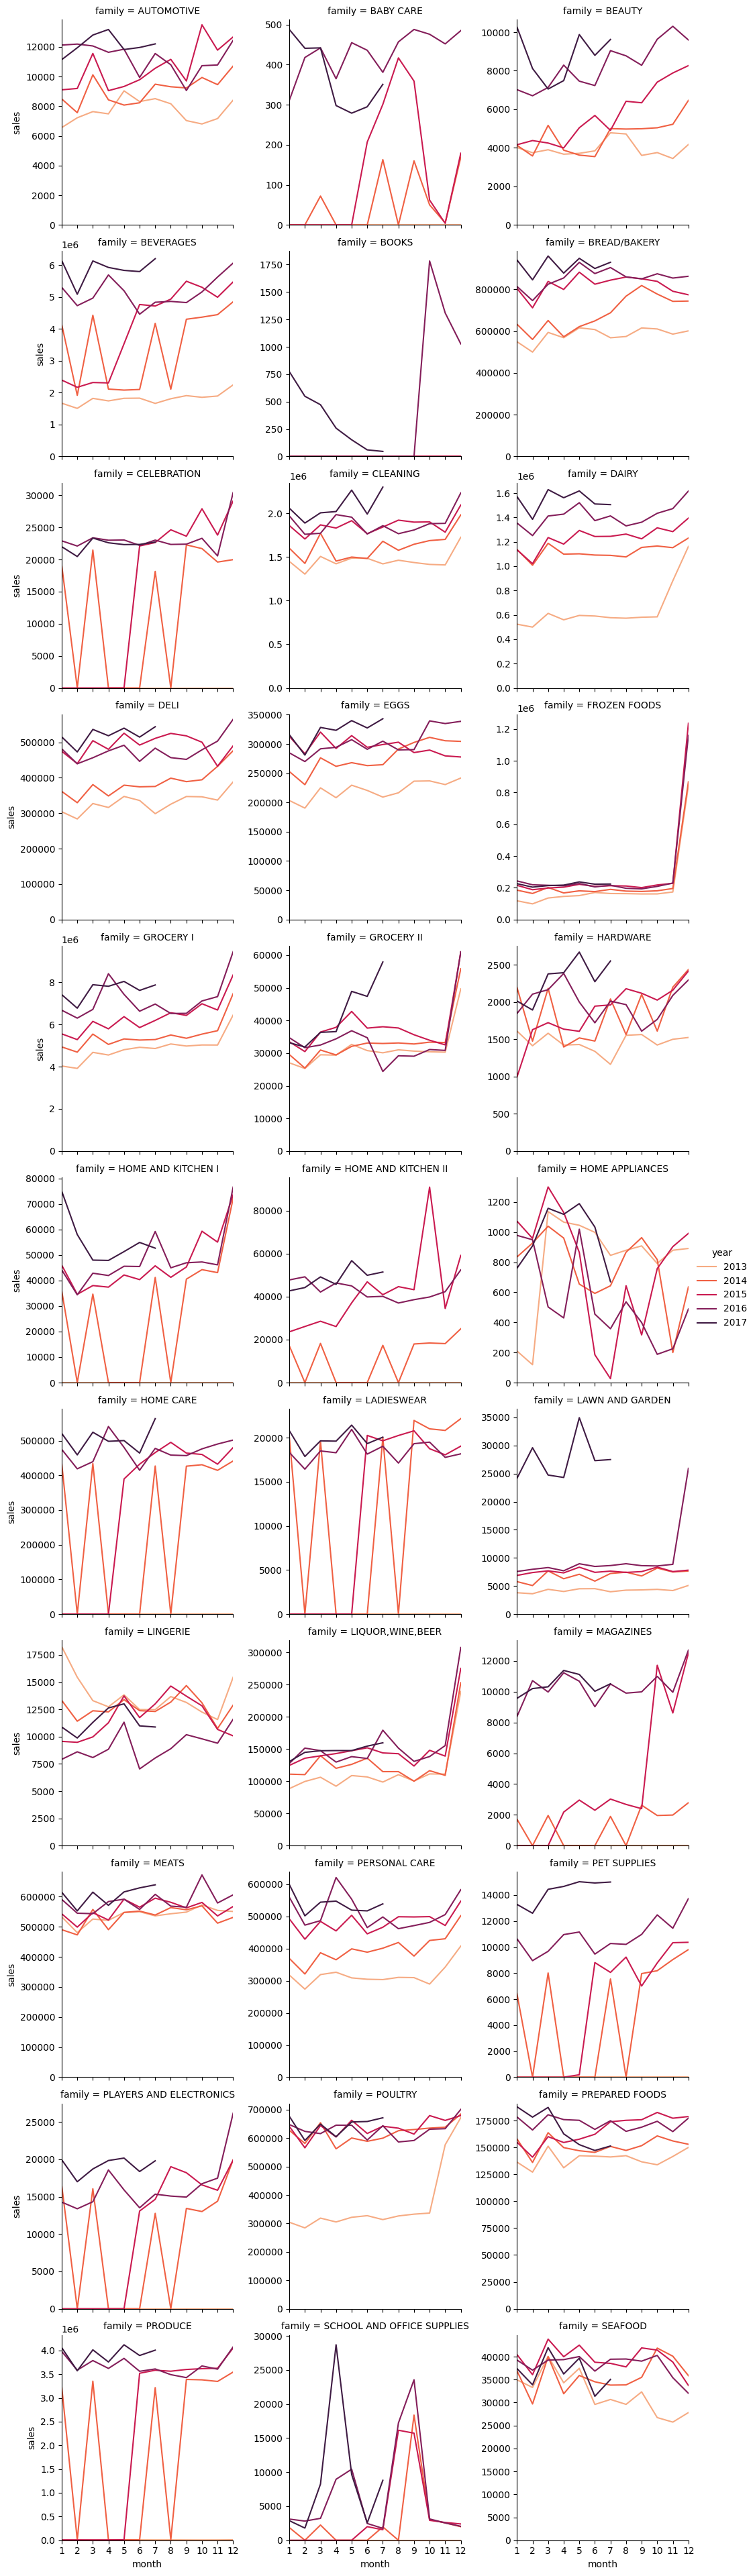

In [34]:
#Analizamos la estacionalidad por categoría de producto
original_train = pd.read_csv('train.csv')
original_test = pd.read_csv('test.csv')

original_train['date'] = pd.to_datetime(original_train['date'])
original_train['year'] = original_train['date'].dt.year
original_train['month'] = original_train['date'].dt.month

monthly_sales = original_train.groupby(['family', 'year','month']).agg({"sales" : "sum"}).reset_index()

# The value of the last month (for each 33 products) we change to nan, as otherwise it will distort
# the graph since this month's data is incomplete:
for x in range(33):
    z = 55+(x*56)
    monthly_sales.at[z,'sales'] = np.nan

# We use seaborn's FacetGrid with a col_wrap of 3 to show all the graphs in rows of three.
# We also need sharey = False so that the y axis of all the graphs is not shared but individual.
product_lineplots = sns.FacetGrid(monthly_sales, col="family", hue='year', sharey=False, height=3.5, col_wrap=3, palette='rocket_r')
product_lineplots.map(sns.lineplot, "month", 'sales')
product_lineplots.add_legend()
product_lineplots.set(xlim=(1, 12), ylim=(0, None), xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

Coomo podemos ver, la estacionalidad existe, pero no siempre de forma totalmente ajustada. El caso más claro es el de School and office supplies, una de las categorías que peor funcionaban en validación del prophet básico.

Nuestro dataset de validación abarca el mes de junio. Sin embargo, viendo los datos completos, vemos que en este mes el pico de ventas se ha adelantado respecto de la estacionalidad de otros años. La media móvil nos previene los esfectos de estas estacionalidades no plenamente ajustadas

RED LSTM

In [ ]:
# 1.- Cargar librerías
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tqdm import tqdm  # Para visualizar el progreso

# 2.- Cargar los datos de entrenamiento y test
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Convertir fechas a datetime
df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])

# 3.- Codificar `store_nbr` y `family` como números
le_store = LabelEncoder()
le_family = LabelEncoder()

df_train["store_nbr"] = le_store.fit_transform(df_train["store_nbr"])
df_test["store_nbr"] = le_store.transform(df_test["store_nbr"])

df_train["family"] = le_family.fit_transform(df_train["family"])
df_test["family"] = le_family.transform(df_test["family"])

# 4.- Normalizar ventas por tienda y familia
scalers = {}  # Guardaremos los escaladores por cada tienda y familia
df_train["sales_scaled"] = np.nan  # Creamos la columna de ventas normalizadas

for (store, family) in tqdm(df_train.groupby(["store_nbr", "family"]).size().index, desc="Normalizando ventas"):
    mask = (df_train["store_nbr"] == store) & (df_train["family"] == family)
    scaler = MinMaxScaler()
    df_train.loc[mask, "sales_scaled"] = scaler.fit_transform(df_train.loc[mask, ["sales"]])
    scalers[(store, family)] = scaler  # Guardamos el escalador para desescalar después

# 5.- Crear datos de entrenamiento con ventana deslizante
look_back = 30
X_train, y_train = [], []

for (store, family) in tqdm(df_train.groupby(["store_nbr", "family"]).size().index, desc="Creando secuencias"):
    df_store_family = df_train[(df_train["store_nbr"] == store) & (df_train["family"] == family)]

    if len(df_store_family) > look_back:
        for i in range(len(df_store_family) - look_back):
            seq_x = df_store_family.iloc[i:i+look_back][["sales_scaled", "store_nbr", "family"]].values
            seq_y = df_store_family.iloc[i+look_back]["sales_scaled"]

            X_train.append(seq_x)
            y_train.append(seq_y)

X_train, y_train = np.array(X_train), np.array(y_train)

# 6.- Definir el modelo LSTM optimizado
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 3)),  # Ahora usamos 3 features
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

# 7.- Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# 8.- Preparar los datos de test para predicción
df_test["sales"] = np.nan  # Inicializamos la columna de predicciones

for (store, family) in tqdm(df_test.groupby(["store_nbr", "family"]).size().index, desc="Generando predicciones"):
    df_test_filtered = df_test[(df_test["store_nbr"] == store) & (df_test["family"] == family)]

    if (store, family) in scalers:
        scaler = scalers[(store, family)]

        # Obtener los últimos 30 días de ventas escaladas
        last_30_days = df_train[(df_train["store_nbr"] == store) & (df_train["family"] == family)].tail(look_back)

        if len(last_30_days) < look_back:
            continue  # Saltar si no hay suficientes datos

        X_test = last_30_days[["sales_scaled", "store_nbr", "family"]].values.reshape(1, look_back, 3)

        predictions = []
        for _ in range(len(df_test_filtered)):
            pred_scaled = model.predict(X_test)[0][0]
            predictions.append(pred_scaled)

            # Agregar la predicción a los datos de entrada para la siguiente iteración
            new_entry = np.array([[pred_scaled, store, family]])
            X_test = np.append(X_test[:, 1:, :], new_entry.reshape(1, 1, 3), axis=1)

        # Desnormalizar las predicciones
        predictions_descaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
        df_test.loc[df_test_filtered.index, "sales"] = predictions_descaled

# 9.- Asegurar valores no negativos
df_test["sales"] = df_test["sales"].clip(lower=0)

#10.- Guardar el archivo de submisión
df_submission = df_test[["id", "sales"]]
df_submission.to_csv("submission_lstm_store_family.csv", index=False)

print(" Archivo 'submission_lstm_store_family.csv' generado y listo para Kaggle!")